### Diplom thesis
- vyzkouset/najit spravnou **architekturu neuronove site** (LSTM 2-3 vnitrni vrstvy, droup out vyzkouset, zmensovani velikosti vrstev, hyperopt, pouzit Keras?)
- **optimalizace parametru** neuronove site
- provest **uceni neuronove site** (to mozna nechat na konec, provest 20x-30x beh nebo cross validaci -> zprumerovat? at je to pouzitelne ono to vychazi dost ruzne)

In [1]:
# keras module for building LSTM 
import pandas as pd
import numpy as np
import string, os 
import math
from matplotlib import pyplot as plt
import re
import ast
import itertools
import pickle
from numpy import array
import math
from collections import Counter
from functools import partial
from sklearn.metrics import r2_score

from tensorflow.keras.utils import to_categorical
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from SmilesPE.pretokenizer import atomwise_tokenizer
import codecs
from SmilesPE.tokenizer import *
from SmilesPE.spe2vec import *
from SmilesPE.pretokenizer import kmer_tokenizer

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D

# from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor 

import keras.utils as ku 
from keras import models 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from hyperopt.pyll.base import scope 
from hyperopt import pyll, hp, Trials, fmin, tpe, STATUS_OK

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data

In [2]:
df = pd.read_csv('../data/VEGF2_ChEMBL28-10980_pic50_noDuplicate_canSmiles_sln_deepSmiles_selfies_inchi.csv',sep=',')

linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
for notName in linearNotation_names:
    df[notName+'_length'] = df[notName].str.len()
print(df.shape)
# canonical_smiles_length
dfClean = df.loc[(df['canonical_smiles_length'] >30) & (df['canonical_smiles_length']<80)]
print(dfClean.shape)

(7159, 11)
(7044, 11)


#### Pomocne funkce

In [3]:
def addCharAtBeginningEnd(temp):
    lst=[]
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [4]:
def splitByAtomwiseTokenizer(chem_notation):
    lst=[]
    temp = atomwise_tokenizer(chem_notation)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [5]:
def removeBeginningInChI(chem_notation,substring):
    res = chem_notation.replace(substring,'')
    return res

In [6]:
def tokenizationBPEChemLinearNotaion(col_name,df):
    fileName = 'data_for_tokenizer/tokenizer-wiki_'+str(col_name)+'.json' 
    fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=fileName)
    return df[col_name].apply(lambda chem_notaion: fast_tokenizer.tokenize(str(chem_notaion)))

In [7]:
def addCharacterStartEndSequenceSplitByCharacters(chem_notation):
    chem_notation = "^" + chem_notation + "$"
    lst = [c for c in chem_notation]
    return lst

In [8]:
def tokenizeChemNotation(chem_notation,col_name): 
    spe_vob= codecs.open('SPE_ChEMBL_'+str(col_name)+'.txt')
    spe = SPE_Tokenizer(spe_vob)
    lst = spe.tokenize(chem_notation)
    lst = lst.split(' ')
    return lst

In [9]:
def splitByKmerTokenizer(chem_notation):
    lst=[]
    temp = kmer_tokenizer(chem_notation, ngram=4, stride=1, remove_last = False, exclusive_tokens = None)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [10]:
# vytvorit list token id + padding 
def createListTokensId(chem_notation, vocabulary):
    # chem_notation je list tokenu / uz je pocatecni a koncovy znak ^, $
    token_id_list=[]
    for c in chem_notation:
        if(c in vocabulary):
            token_id_list.append(vocabulary[c])
    return token_id_list

In [11]:
def cutVecTokens(x,max_length):
    if(max_length >= len(x)):
        return x
    x = x[:max_length-2]
    x.append('$')
    return x

In [12]:
# kontrola, rozdeleni data tak je vzdy stejne i kdyz pouziji data pro jiny chem. lin. zapis
def splitData(list_token, ys, RANDOM_STATE):  
    X_train, X_test, y_train, y_test = train_test_split(list_token, ys, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE) # 0.25 x 0.8 = 0.2
    return X_train,y_train,X_val,y_val,X_test,y_test

In [13]:
# vytvoreni modelu s tunnenim parametru
def create_model(units1,layers,units2,units3,l_rate, X_train):
    opt = keras.optimizers.Adam(learning_rate=l_rate)
    model = Sequential()
    
    model.add(Bidirectional(LSTM(units=units1, input_shape=(X_train.shape[1],X_train.shape[2]))))
    model.add(Dropout(rate=0.5))
    # Middle layers return sequences
    for i in range(layers-2):
        model.add(Dense(units=units2))
        model.add(Dropout(rate=0.5))

    # Last layer doesn't return anything
    model.add(Dense(units=units3))
    model.add(Dropout(rate=0.5))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=opt ,metrics=['mse'])
    return model

In [14]:
def saveModelLossPlot(result,chem_notation,modelLossPlot_fileName,tokenization):
    # plot training history
    plt.figure(figsize=(10,10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss - '+tokenization+' '+chem_notation)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(modelLossPlot_fileName)

In [15]:
def plotPredictReal(predictions,y_test,tokenization,chem_notation,predictionsPlot_fileName):
    # plotPredictReal(y_pred, y_test,tokenization,chem_notation,predictionsPlot_fileName)
        plt.figure(figsize=(10,10))
        plt.scatter(y_test, predictions, c='crimson')
        p1 = max(max( predictions), max(y_test))
        p2 = min(min( predictions), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.title(tokenization+' '+chem_notation, fontsize=15)
        plt.xlabel('True value', fontsize=15)
        plt.ylabel('Prediction', fontsize=15)
        plt.axis('equal')
        plt.show
        plt.savefig(predictionsPlot_fileName)

In [16]:
# objective funkce pro hyperopt s cross validaci
def objective(params, X_train, y_train, n_patience, idx, cut_length,RANDOM_STATE):
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=n_patience)
    
    model_nn = KerasRegressor(build_fn = create_model,**params, X_train=X_train, epochs = 400, verbose = 0)
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model_nn, X_train, y_train,scoring='neg_mean_squared_error', cv=kfold,fit_params={'callbacks':[es]},error_score='raise')
    
    score = scores.mean()
    std = scores.std()
    loss = -score
    print('params:\t',params)
    print('score:\t',loss)
    print('std:\t',std)
    
    # Dictionary with information for evaluation
    return {
        'loss': loss,
        'params': params,
        'std' : std,
        'status': STATUS_OK }

In [25]:
# vytvoreni modelu s tunnenim parametru
def builtModelBestParams(params,cut_length,X_train):
    opt = keras.optimizers.Adam(learning_rate=params['l_rate'])
    model = Sequential()
    # First layer specifies input_shape and returns sequences
    model.add(Bidirectional(LSTM(units=params['units1'], input_shape=(X_train.shape[1],X_train.shape[2]))))
    model.add(Dropout(rate=0.5))
    # Middle layers return sequences
    for i in range(params['layers']-2):
        model.add(Dense(units=params['units2']))
        model.add(Dropout(rate=0.5))

    # Last layer doesn't return anything
    model.add(Dense(units=params['units3']))
    model.add(Dropout(rate=0.5))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=opt ,metrics=['mse'])
    return model

In [18]:
def builtModelWithBestParams(best_params,cut_length,cut_data,j,bestModel_fileName,modelHistory_fileName, bestParams_fileName,predictions_fileName,modelLossPlot_fileName,predictionsPlot_fileName,n_patience,encoding,chem_notation,tokenization,X_train,y_train,X_val,y_val,X_test,y_test):
    model = builtModelBestParams(best_params,cut_length,X_train)
    mc = ModelCheckpoint(bestModel_fileName, monitor='val_loss', mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
    
    # train model
    result = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=400,verbose=0, callbacks=[es,mc])
    # store information
    # ----------------------------------------- BEST MODEL ---------------------------------------
    best_model = models.load_model(bestModel_fileName)
    # model prediction
    y_pred = best_model.predict(X_test)
    results_eval = best_model.evaluate(X_test, y_test)
    print('\nn_patience:  ', n_patience)
    print('max_length:  ',cut_length)
    print('results:',results_eval ,end='\n')
    plotPredictReal(y_pred, y_test,tokenization,chem_notation,predictionsPlot_fileName)
    saveModelLossPlot(result,chem_notation,modelLossPlot_fileName,tokenization)
    
    # TADY S TIM NECO PROVEST - jetli pouziji tak do definice funkce pridat
    #store information
    # ----------------------------------------- HISTORY ---------------------------------------
    with open(modelHistory_fileName, 'w') as f:
        np.save(modelHistory_fileName,result.history)
    # ----------------------------------------- BEST PARAMS ---------------------------------------
    a_file = open(bestParams_fileName, "wb")
    pickle.dump(best_params, a_file)
    a_file.close()
    # ----------------------------------------- PREDICTIONS ---------------------------------------
    prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv(predictions_fileName)
    
    r2 = r2_score(y_test, y_pred)
    return results_eval,r2

In [19]:
def tokenizeOneHotEncoding(df,linearNotation_name,tokenization,lengths_lst_tokenIdxs,j):
    substring = 'InChI=1S/'
    df['inchi'] = df['inchi'].apply(lambda chem_notation: removeBeginningInChI(chem_notation,substring))
    col_name = linearNotation_name
    token_col_name = col_name+'_tokens'
    tokenIndex_col_name = col_name+'_tokenIndexList'

    if(tokenization == 'atom'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByAtomwiseTokenizer(chem_notation))
    elif(tokenization == 'bpe'):
        df[token_col_name] = tokenizationBPEChemLinearNotaion(col_name,df)
        df[token_col_name] = df[token_col_name].apply(lambda lst_tokens: addCharAtBeginningEnd(lst_tokens))
    elif(tokenization == 'char'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: addCharacterStartEndSequenceSplitByCharacters(chem_notation))
    elif(tokenization == 'spe'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: tokenizeChemNotation(chem_notation,col_name))
    elif(tokenization == 'kmer'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByKmerTokenizer(chem_notation))

    max_length = lengths_lst_tokenIdxs[tokenization][j]
    df[token_col_name] = df[token_col_name].apply(lambda x: cutVecTokens(x,max_length))
    CHEM_NOTATION_CHARS = set(df[token_col_name].apply(list).sum())
    print(max_length)
    print(len(CHEM_NOTATION_CHARS))
    
    if(len(CHEM_NOTATION_CHARS) * max_length > 100000):
        tempN = ((len(CHEM_NOTATION_CHARS) * max_length)-100000)/max_length
        n = math.floor(len(CHEM_NOTATION_CHARS)-tempN)
        n = len(CHEM_NOTATION_CHARS)-n
        print('n =',n)
        
        temp = df[token_col_name].tolist()
        flat_list = [item for sublist in temp for item in sublist]
        count_flatList = Counter(flat_list)
        keysSort = [pair[0] for pair in sorted(count_flatList.items(), key=lambda item: item[1],reverse=False)]
        
        print(n)
        for i in range(n):
            del count_flatList[keysSort[i]]
        CHEM_NOTATION_CHARS = count_flatList.keys()
        print('nova delka: ',len(CHEM_NOTATION_CHARS))
    
    vocabulary = {c: i+2 for i,c in enumerate(set(CHEM_NOTATION_CHARS))}
    df[tokenIndex_col_name] = df[token_col_name].apply(lambda chem_notation: createListTokensId(chem_notation, vocabulary))
    
    res = df[tokenIndex_col_name].apply(lambda tokenIndex: tokenIndex).tolist()
    vector_with_padding = pad_sequences(res, maxlen=max_length, padding='post', truncating='post')
    df[tokenIndex_col_name] = [vector_with_padding[i] for i in range(len(vector_with_padding))]
    
    data = array(df[tokenIndex_col_name].tolist())
    oneHotEncoding = to_categorical(data)
    
    return np.array(oneHotEncoding)

# Trenovani neuronove site

-----------------------------------------------------------------------------
atom
-----------------------------------------------------------------------------
bpe

canonical_smiles
30
3295
Epoch 00023: early stopping                          
Epoch 00027: early stopping                          
Epoch 00024: early stopping                          
Epoch 00018: early stopping                          
Epoch 00021: early stopping                          
Epoch 00020: early stopping                          
Epoch 00029: early stopping                          
Epoch 00022: early stopping                          
Epoch 00022: early stopping                          
Epoch 00021: early stopping                          
params:	                                             
{'l_rate': 0.017505994137028826, 'layers': 2, 'units1': 32, 'units2': 16, 'units3': 32}
score:	                                              
0.7285256199120453                                   
std:	              

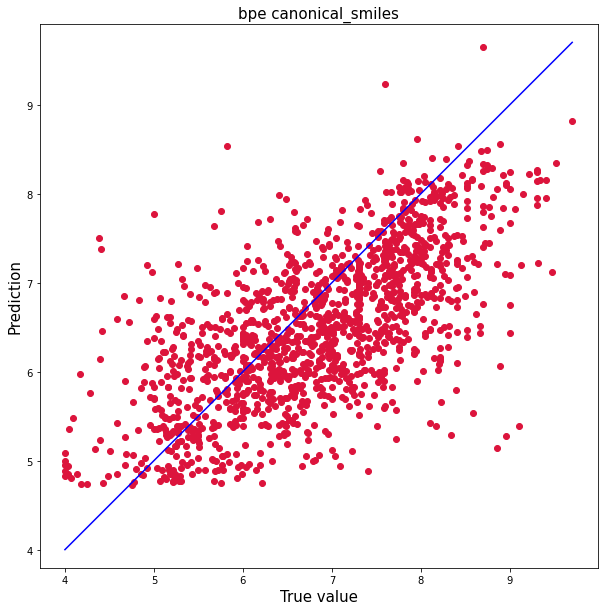

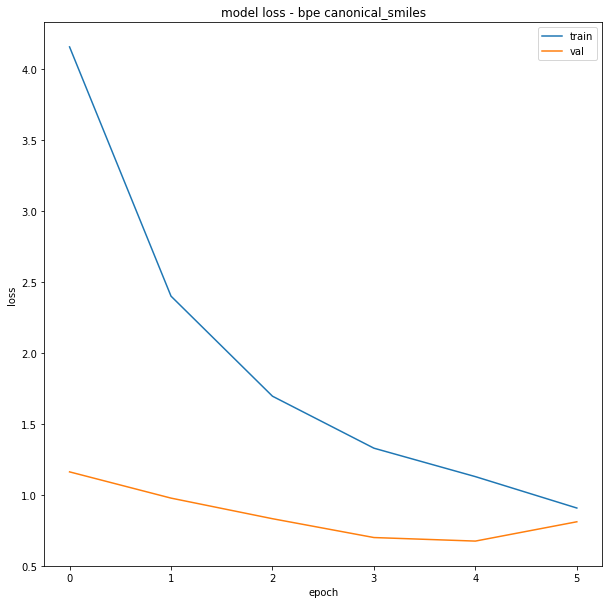

In [32]:
# budu delat postupne po tokenizacich, abych to mohla kontrolovat
#DEFINIICE PROMENNYCH
tokenization_names = ['atom','bpe','char','spe','kmer']
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
encoding = 'oneHot'
m_e=2
n_patience = 1
RANDOM_STATE=42

df_score = {'tokenization': ['empty'], 'chem_notation': ['empty'],'score_cross_val':['empty'],'std_cross_val':['empty'],'loss_mse':['empty'],'metric_mse':['empty'],'r2':['empty']}
df_score = pd.DataFrame(df_score)

fileNameScore = '../data/final_results/'+encoding+'/scoreCrossVal.csv'
# kontrola, jestli soubor neexistuje, kdyz poustim znova
if os.path.exists(fileNameScore):
    os.remove(fileNameScore)
df_score.to_csv(fileNameScore,sep=',',header=True,index=False)

lengths_lst_tokenIdxs = {   'atom':[60,90,65,62,160],
                            'char':[62,105,70,300,160],
                            'kmer':[60,92,65,60,160],
                            'bpe':[30,62,24,125,90],
                            'spe':[13,8,7,31,43]}
or_unitsLst = [16, 32, 64, 128]
ys = np.array(dfClean['value'])

# ITERATE OVER TOKENIZATION
for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    print('-----------------------------------------------------------------------------\n'+tokenization)
    df_score['tokenization'][0] = tokenization
    # if(not(tokenization =='kmer')):
    #         continue
    # ITERATE OVER LINEAR CHEMICAL NOTATION
    difSmallNum=5000
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j]
        if(not(tokenization == 'bpe' and chem_notation =='canonical_smiles')):
            continue
        print('\n'+chem_notation)
        df_score['chem_notation'][0] = chem_notation
        cut_length = lengths_lst_tokenIdxs[tokenization][j]
        
        # vybrani poctu neuronu pro vstupni vrstvu
        for u in range(len(or_unitsLst)):
            if(or_unitsLst[u]>cut_length):
                difGreatNum = abs(or_unitsLst[u] - cut_length)
                if(u!=0):
                    difSmallNum = abs(or_unitsLst[u-1] - cut_length)
                if(difGreatNum <= difSmallNum):    
                    nUnits = [or_unitsLst[u]]
                    unitsLst = or_unitsLst[:(u+1)]
                    break
                else:
                    nUnits = [or_unitsLst[u-1]]
                    unitsLst = or_unitsLst[:(u)]
                    break
            elif(or_unitsLst[u]==cut_length or u==(len(or_unitsLst)-1)):
                nUnits = [or_unitsLst[u]]
                unitsLst = or_unitsLst[:(u+1)]
                break
                 
        
        # print('cut_length ',cut_length)
        # print('nUnits',nUnits)
        # print('unitsLst\n',unitsLst)
              
        space = {'units1'     : hp.choice('units1', nUnits),
         'units2'             : hp.choice('units2', unitsLst),
         'units3'             : hp.choice('units3', unitsLst),
         'layers'             : scope.int(hp.quniform('layers',2,3,1)),
         'l_rate'             : hp.loguniform('l_rate', np.log(0.01), np.log(0.2))
        }
        
        data = tokenizeOneHotEncoding(dfClean.copy(),chem_notation,tokenization, lengths_lst_tokenIdxs,j)

        X_train,y_train,X_val,y_val,X_test,y_test = splitData(data, ys, RANDOM_STATE)  
        
        # print(np.isnan(X_train).any(), np.isinf(X_train).any())
        # print(np.isnan(y_train).any(),np.isinf(y_train).any())
        # print(np.isnan(X_val).any(),np.isinf(X_val).any())
        # print(np.isnan(y_val).any(),np.isinf(y_val).any())
        # print(np.isnan(X_test).any(),np.isinf(X_test).any())
        # print(np.isnan(y_test).any(),np.isinf(y_test).any())
        
        
        # definice nazvu pro ukladani
        startName = '../data/final_results/'+encoding+'/'+tokenization+'/'
        bestModel_fileName = startName+'bestModels/'+chem_notation+'.h5'
        modelHistory_fileName = startName+'history/'+chem_notation+'.npy'
        modelLossPlot_fileName = startName+'lossPlot/'+chem_notation+'.png'
        bestParams_fileName = startName+'bestParams/'+chem_notation+'.pkl'
        predictions_fileName = startName+'predictions/'+chem_notation+'.csv'
        predictionsPlot_fileName = startName+'predictionsPlot/'+chem_notation+'.png'
        
        # zatim mam jen chemicke linearni zapisy
        fmin_objective = partial(objective, n_patience = n_patience, idx=j ,cut_length = cut_length,X_train=X_train,y_train=y_train,RANDOM_STATE=RANDOM_STATE)
        
        bayes_trials = Trials()
        best = fmin(fn = fmin_objective, space = space, algo = tpe.suggest, max_evals = m_e, trials = bayes_trials)#, rstate = np.random.RandomState(50))

        best_loss = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['loss']
        best_std = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['std']
        best_params = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['params']
        print('best params:\n',best_params,'\nbest loss:\n',best_loss,'\nbest std:\n',best_std,end = '\n')
    
        df_score['score_cross_val'][0] = best_loss
        df_score['std_cross_val'][0] = best_std
        
        # natrenovani jednoho modelu s nejlepsimy parametry
        results_eval,r2 = builtModelWithBestParams(best_params,cut_length,data,j,bestModel_fileName,modelHistory_fileName, bestParams_fileName,
                                 predictions_fileName,modelLossPlot_fileName,predictionsPlot_fileName,n_patience,encoding,chem_notation,
                                 tokenization,X_train,y_train,X_val,y_val,X_test,y_test)
        
        df_score['loss_mse'][0] = results_eval[0]
        df_score['metric_mse'][0] = results_eval[1]
        df_score['r2'][0] = r2
        df_score.to_csv(fileNameScore, mode='a', index=False, header=False)